In [1]:
!pip install pyarrow==5.0.0

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# ATLAS $H \rightarrow ZZ \rightarrow \ell \ell \ell \ell$ Public Outreach Example

ATLAS has released its higgs discovery dataset as public data:

* Use `ServiceX` to stream the 4 lepton data
* Use `coffea` and `awkward` to produce the final $m_{4\ell}$ plots.
* This is **only** aboput 0.5 GB worth of data!

Outline

1. Use `ServiceX` for general quality and object selection
1. Use `coffea` and `awkward` to do multi-object event wide selection and plots
1. Produce the plot for running on a single MC file
1. Run on all the MC and Data files

In [2]:
from func_adl_servicex import ServiceXSourceUpROOT
from servicex.servicex import ServiceXDataset
from coffea.processor.servicex import Analysis, DataSource, LocalExecutor, DaskExecutor
from func_adl import ObjectStream
from hist import Hist

import asyncio
from typing import List

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

## Selecting events and clean objects

The ATLAS analysis ...

First we create the representative data source, and apply the initial trigger requirement:

In [3]:
ds = ServiceXSourceUpROOT('cernopendata://dummy',  "mini", backend_name='uproot')
ds.return_qastle = True  # Magic

good_events = (ds
               .Where(lambda e: e.trigE or e.trigM)
              )

Next, basic lepton selection:

* Turn the columnar representation into object so we can make cuts
* Apply the common base cuts for electrons and muons
* We also need the event weights, which are baked into the ntuple

In [4]:
all_leptons = (good_events
                .Select(lambda e: (
                    Zip({
                        'lep_pt': e.lep_pt,
                        'lep_eta': e.lep_eta,
                        'lep_phi': e.lep_phi,
                        'lep_energy': e.lep_E,
                        'lep_charge': e.lep_charge,
                        'lep_ptcone30': e.lep_ptcone30,
                        'lep_etcone20': e.lep_etcone20,
                        'lep_typeid': e.lep_type,
                        'lep_trackd0pvunbiased': e.lep_trackd0pvunbiased,
                        'lep_tracksigd0pvunbiased': e.lep_tracksigd0pvunbiased,
                        'lep_z0': e.lep_z0,
                    }),
                    e.mcWeight,
                    e.scaleFactor_ELE*e.scaleFactor_MUON*e.scaleFactor_LepTRIGGER*e.scaleFactor_PILEUP,
                ))
               )

In [5]:
good_leptons = (all_leptons
                .Select(lambda e: {
                    'ele': e[0]
                           .Where(lambda lep: lep.lep_typeid == 11)
                           .Where(lambda lep: (lep.lep_pt > 7000)
                                              and (abs(lep.lep_eta) < 2.47)
                                              and (lep.lep_etcone20/lep.lep_pt < 0.3)
                                              and (lep.lep_ptcone30/lep.lep_pt < 0.3)
                                              and (abs(lep.lep_trackd0pvunbiased) / lep.lep_tracksigd0pvunbiased < 5)
                                 ),
                    'mu': e[0]
                           .Where(lambda lep: lep.lep_typeid == 13)
                           .Where(lambda lep: (lep.lep_pt > 5000)
                                              and (abs(lep.lep_eta) < 2.5)
                                              and (lep.lep_etcone20/lep.lep_pt < 0.3)
                                              and (lep.lep_ptcone30/lep.lep_pt < 0.3)
                                              and (abs(lep.lep_trackd0pvunbiased) / lep.lep_tracksigd0pvunbiased < 3)
                                 ),
                    'mcWeight': e[1],
                    'scaleFactor': e[2],
                })
               )

And finally, we have to turn this into a form that coffea can currently understand.

* We only need to feed columns we will use downstream out of `ServiceX`, reducing the dataload.

In [6]:
atlas_selection = (good_leptons
                   .Select(lambda e: {
                       'electrons_pt': e.ele.lep_pt,
                       'electrons_eta': e.ele.lep_eta,
                       'electrons_phi': e.ele.lep_phi,
                       'electrons_energy': e.ele.lep_energy,
                       'electrons_charge': e.ele.lep_charge,
                       'electrons_z0': e.ele.lep_z0,
                       'muons_pt': e.mu.lep_pt,
                       'muons_eta': e.mu.lep_eta,
                       'muons_phi': e.mu.lep_phi,
                       'muons_energy': e.mu.lep_energy,
                       'muons_charge': e.mu.lep_charge,
                       'muons_z0': e.mu.lep_z0,
                       'mcWeight': e.mcWeight,
                       'scaleFactor': e.scaleFactor,
                   })
                  )

## Performing the analysis

The data from `ServiceX` is now analyzed by `awkward` and `coffea`.

* `coffea` automatically builds _event_ layout for electorns and muons, queuing off the prefix in the names from `ServiceX`
* `coffea` recognizes that $p_T$, $\eta$, $\phi$, and $E$ are availible, and builds a 4-vector that has a `theta` property.
* `awkward` properly translates the `np.sin` to work on an `awkward` array.

In [7]:
class ATLAS_Higgs_4L(Analysis):
    '''Run the 4 Lepton analysis on ATLAS educational ntuples
    '''
    @staticmethod
    def process(events):
        from collections import defaultdict
        import numpy as np

        import awkward as ak

        sumw = defaultdict(float)
        mass_hist = (Hist.new
                     .Reg(60, 60, 180, name='mass', label='$m_{4\ell}$ [GeV]')
                     .StrCat([], name='dataset', label='Cut Type', growth=True)
                     .StrCat([], name='channel', label='Channel', growth=True)
                     .Int64()
                    )

        dataset = events.metadata['dataset']
        electrons = events.electrons
        muons = events.muons
        
        weight =  ak.Array(np.ones(len(events.scaleFactor))) if events.metadata['is_data'] \
            else events.scaleFactor*events.mcWeight

        # We didn't have the 4-vector in `ServiceX`, so we couldn't do the final good-object cut.
        # Good electon selection
        electrons_mask = (abs(electrons.z0*np.sin(electrons.theta)) < 0.5)
        electrons_good = electrons[electrons_mask]

        # Good muon selection
        muons_mask = (abs(muons.z0*np.sin(muons.theta)) < 0.5)
        muons_good = muons[muons_mask]

        # Next are event level cuts
        
        # In order to cut in sorted lepton pt, we have to rebuild a lepton array here
        leptons_good = ak.concatenate((electrons_good, muons_good), axis=1)
        leptons_good_index = ak.argsort(leptons_good.pt, ascending=False)
        leptons_good_sorted = leptons_good[leptons_good_index]

        # Event level cuts now that we know the good leptons
        # - We need to look at 4 good lepton events only
        # - We need same flavor, so check for even numbers of each flavor
        # - all charges must be balenced
        event_mask = (
            (ak.num(leptons_good_sorted) == 4)
            & ((ak.num(electrons_good) == 0) | (ak.num(electrons_good) == 2) | (ak.num(electrons_good) == 4))
            & ((ak.num(muons_good) == 0) | (ak.num(muons_good) == 2) | (ak.num(muons_good) == 4))
            & (ak.sum(electrons_good.charge, axis=1) == 0)
            & (ak.sum(muons_good.charge, axis=1) == 0)
        )
        
        # Next, we need to cut on the pT for the leading, sub-leading, and sub-sub-leading lepton
        leptons_good_preselection = leptons_good[event_mask]
        event_good_lepton_mask = (
            (leptons_good_preselection[:,0].pt > 25000.0)
            & (leptons_good_preselection[:,1].pt > 15000.0)
            & (leptons_good_preselection[:,2].pt > 10000.0)
        )

        # Now, we need to rebuild the good muon and electron lists with those selections
        muons_analysis = muons_good[event_mask][event_good_lepton_mask]
        electrons_analysis = electrons_good[event_mask][event_good_lepton_mask]

        # Lets do eemumu events - as there are no permutations there.abs
        # At this point if there are two muons, there must be two electrons
        eemumu_mask = (ak.num(muons_analysis) == 2)
        muon_eemumu = muons_analysis[eemumu_mask]
        electrons_eemumu = electrons_analysis[eemumu_mask]
        z1_eemumu = muon_eemumu[:,0] + muon_eemumu[:,1]
        z2_eemumu = electrons_eemumu[:,0] + electrons_eemumu[:,1]
        h_eemumu = z1_eemumu + z2_eemumu

        sumw[dataset] += len(h_eemumu)
        mass_hist.fill(
            channel=r'$ee\mu\mu$',
            mass=h_eemumu.mass/1000.0,
            dataset=dataset,
#             weight=weight[eemumu_mask]
        )

        # Next, eeee. For this we have to build permutations and select the best one
        def four_leptons_one_flavor(same_flavor_leptons, event_weights, channel: str):
            fl_positive = same_flavor_leptons[same_flavor_leptons.charge > 0]
            fl_negative = same_flavor_leptons[same_flavor_leptons.charge < 0]
            fl_pairs = ak.cartesian((fl_positive, fl_negative))
            zs = fl_pairs["0"] + fl_pairs["1"]

            delta = abs((91.18*1000.0) - zs.mass[:])
            closest_masses = np.min(delta, axis=-1)
            the_closest = (delta == closest_masses)
            the_furthest = the_closest[:,::-1]

            h_eeee = zs[the_closest] + zs[the_furthest]
            sumw[dataset] += len(h_eeee)
            mass_hist.fill(
                channel=channel,
                mass=ak.flatten(h_eeee.mass/1000.0),
                dataset=dataset,
#                 weight=event_weights,
            )

        four_leptons_one_flavor(electrons_analysis[(ak.num(electrons_analysis) == 4)],
                                weight[(ak.num(electrons_analysis) == 4)],
                                '$eeee$')
        four_leptons_one_flavor(muons_analysis[(ak.num(muons_analysis) == 4)],
                                weight[(ak.num(muons_analysis) == 4)],
                                '$\\mu\\mu\\mu\\mu$')
        
        return {
            "sumw": sumw,
            "mass": mass_hist,
        }

## Run on a MC file

Define a convience function to load MC files - there are a lot of them.

* Note the `is_data` metadata - which was used above in an if statement

In [8]:
def make_ds(name: str, query: ObjectStream):
    '''Create a ServiceX Datasource for a particular ATLAS Open data file
    '''
    from utils import files
    is_data = name == 'data'
    datasets = [ServiceXDataset(files[name]['files'], backend_name='uproot')]
    return DataSource(query=query, metadata={'dataset': name, 'is_data': is_data}, datasets=datasets)

In [9]:
from utils import files
all_datasets = list(files.keys())
', '.join(all_datasets)

'data, ggH125_ZZ4lep, ZH125_ZZ4lep, VBFH125_ZZ4lep, WH125_ZZ4lep, ZqqZll, WpqqWmlv, WplvWmqq, WlvZqq, llll, lllv, llvv, lvvv, Zee, Zmumu, Ztautau'

And an easy routine that will run a single file

* Async so we can run multiple queires at once
* Contains a lot of boiler plate
* Runs on multiple datasets at once (which we will need)

In [10]:
async def run_analysis(names: List[str]):
    'Generate base plot for a multiple datafiles'

    executor = LocalExecutor()
    #executor = DaskExecutor(client_addr="tls://localhost:8786")
    datasources = [make_ds(ds_name, atlas_selection) for ds_name in names]

    # Create the analysis and we can run from there.
    analysis = ATLAS_Higgs_4L()

    async def run_updates_stream(accumulator_stream, name):
        '''Run to get the last item in the stream, with a useful error message'''
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f'Failure while processing {name}') from e
        return coffea_info

    # Run on all items and wait till they are done!
    all_plots = await asyncio.gather(*[run_updates_stream(executor.execute(analysis, source), source.metadata['dataset']) for source in datasources])
    
    all_plots_mass = [p['mass'] for p in all_plots]
    mass = all_plots_mass[0]
    for p in all_plots_mass[1:]:
        mass += p

    return mass

In [11]:
mc_mass_plot = await run_analysis(['ggH125_ZZ4lep'])

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

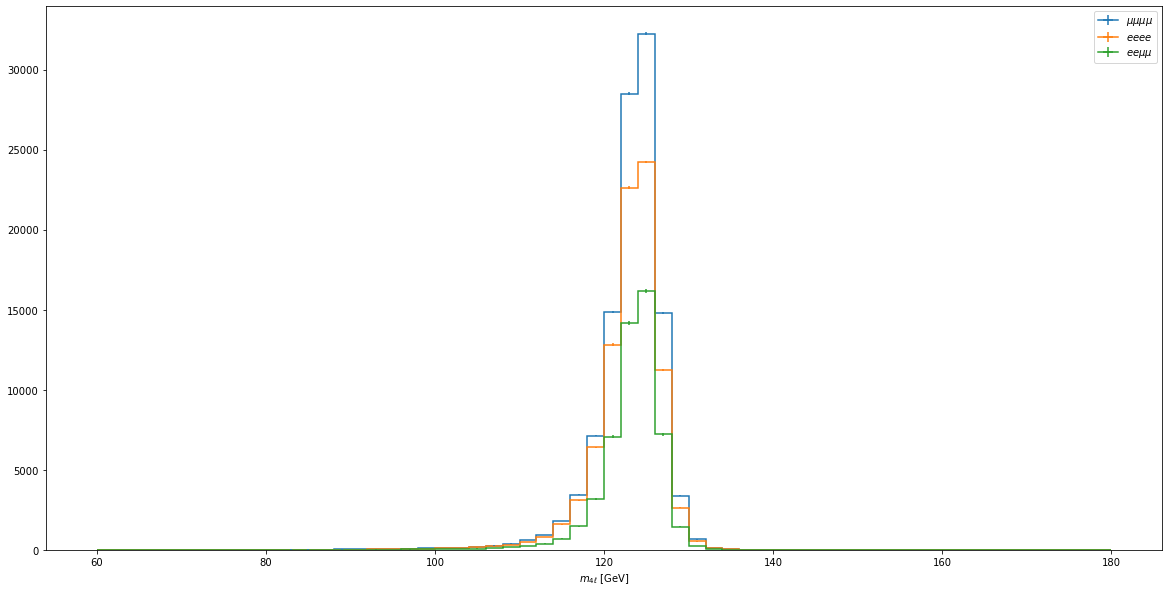

In [12]:
artists = mc_mass_plot.project('mass','channel').plot(stack=True)
ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f612eed4640>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

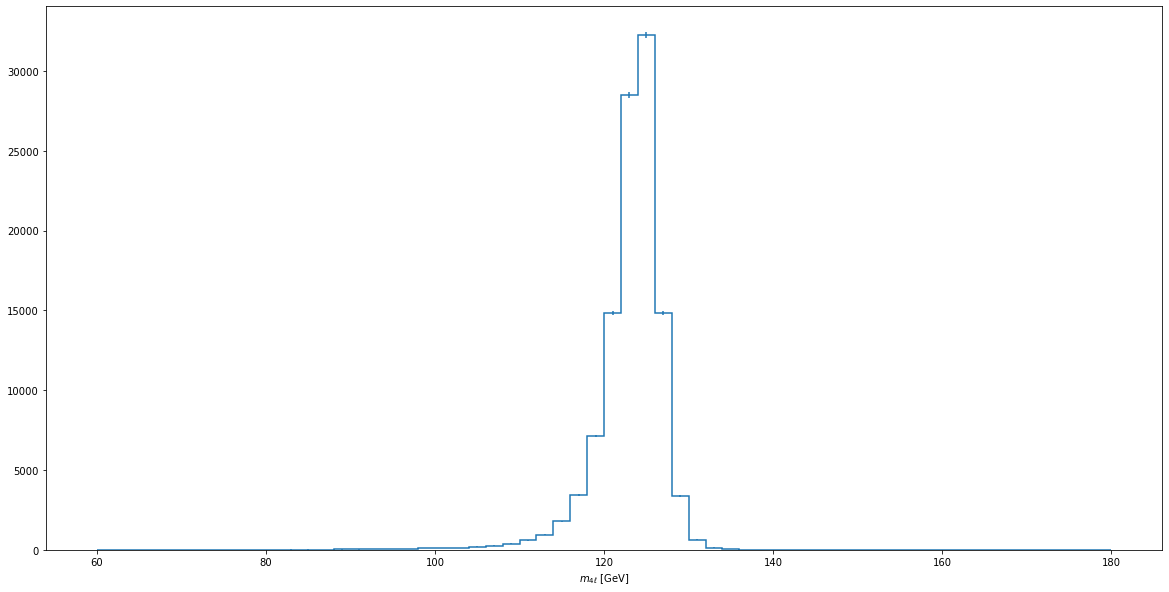

In [13]:
mc_mass_plot.project('mass').plot()

## Running on all MC and Data Files

Here we will repeat the above, but unleash it on all our datasets. These will all be put into a single histogram, with the `dataset` bin marking what sample they are from.

In [14]:
mass_plot = await run_analysis(all_datasets)

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

[root://eospublic.ce...:   0%|          | 0/9000000000.0 [00:00]

        [root://eospublic.ce... Downloaded:   0%|          | 0/9000000000.0 [00:00]

Lets plot everything - not that this is interesting from a physics point of view, but it does make sure everything was added to the histogram in the end!

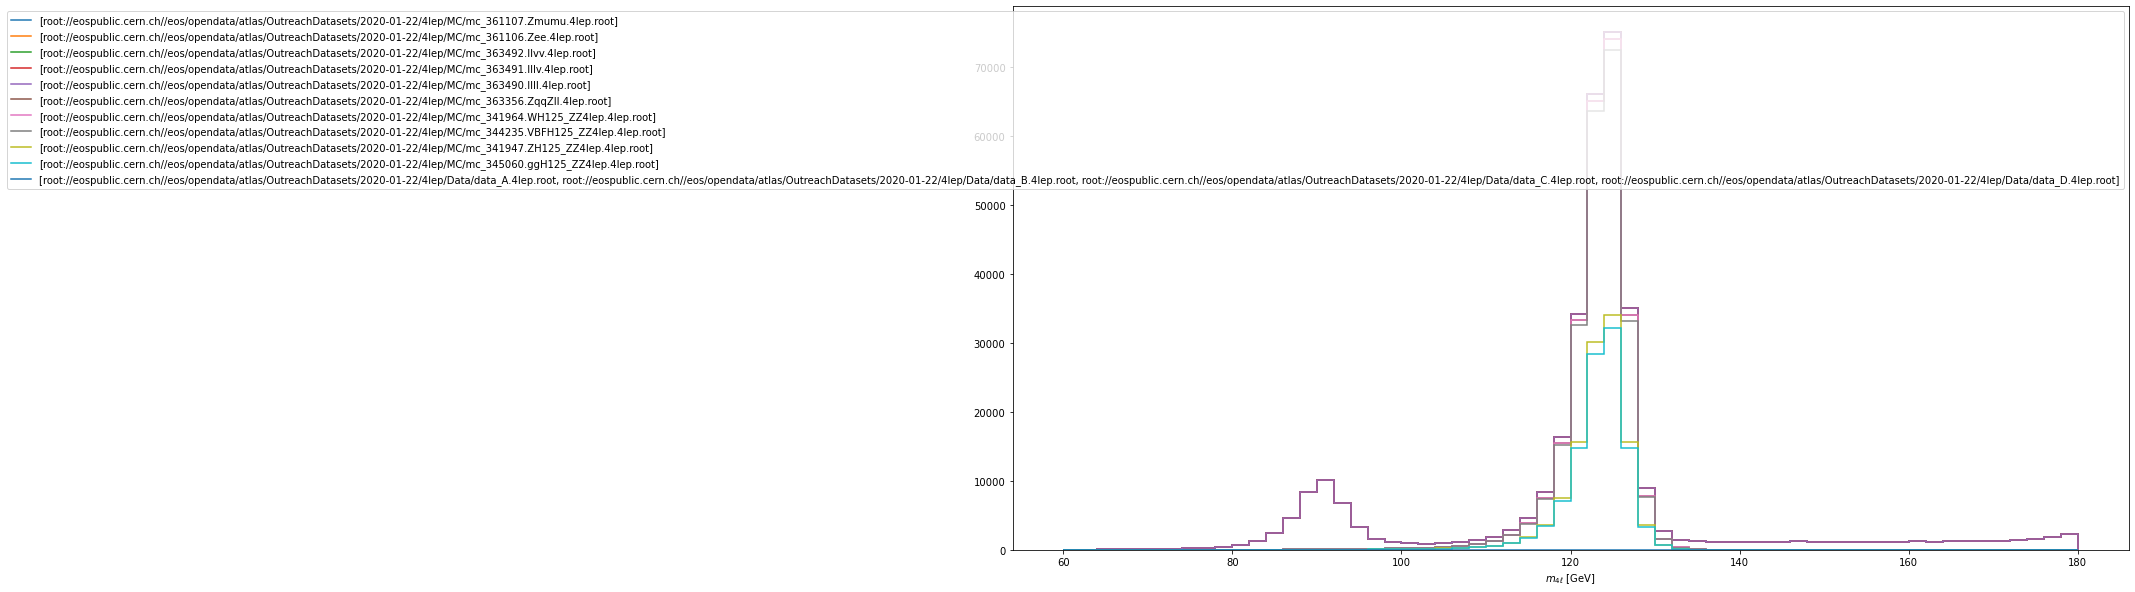

In [15]:
artists = mass_plot.project('mass', 'dataset').plot(stack=True)
ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

First, lets look at the components. We'd like signal, data, and the sum of everything else (MC prediction).

Data:

In [16]:
mass_plot[:, 'data', :].project('mass').plot();

IndexError: index 11 is out of bounds for axis 1 with size 11

Signal:

In [ ]:
signal_ds = list(d for d in all_datasets if 'H125' in d)

artists = mass_plot[:,signal_ds,:].project('mass', 'dataset').plot(stack=True)

ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");

Sum of the backgrounds:

In [ ]:
mc_ds = list(str(i) for i in (set(list(mass_plot.axes[1])) - set(signal_ds) - set(['data'])))
mc_ds.sort()

artists = mass_plot[:,mc_ds,:].project('mass', 'dataset').plot(stack=True)

ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");